In [5]:
import numpy as np
import scipy as sp
import pylab as plt
import matplotlib.pyplot as plt 
import cosmolopy
%matplotlib notebook

In [6]:
## DEFINE YOUR COSMOLOGICAL PARAMETERS
#######################################

omegam, omegab, h, sigma_8, ns = (0.315, 0.0487, 0.673, 0.83, 0.960) ##Planck-13
cosmo = cosmolopy.fidcosmo
cosmo.update({'omega_M_0':omegam, 'omega_lambda_0':1 - omegam, 'omega_k_0':0.0, 'omega_b_0':omegab, 'h':h, 'n':ns, 'sigma_8':sigma_8})

In [7]:
## CREATE A REDHSHIFT ARRAY

z_arr = np.linspace(20.0, 0.0, num=100)


In [8]:
## DEFINE A FUNCTION TO SOLVE THE DIFFERENTIAL EQUATION
#######################################################

def dP_dz(P_z, z, clumping, zeta, Mmin, cosmo):
    T0 = 1.e4
    alpha_B = cosmolopy.reionization.recomb_rate_coeff_HG(T0, 'H', 'B')
    ignore, ignore, ignore, n_H_0 = cosmolopy.density.baryon_densities(**cosmo)
    n_H_0 = n_H_0  / cosmolopy.cc.Mpc_cm ** 3  ### change units
    
    fcoll = cosmolopy.perturbation.collapse_fraction(*cosmolopy.perturbation.sig_del(Mmin, z, passed_min_mass=True, **cosmo))
    recomb_term = - clumping * alpha_B * n_H_0 * (1. + z) ** 3. / (cosmolopy.distance.hubble_z(z, **cosmo) * (1. + z))
    
    return - recomb_term * (P_z + zeta * fcoll)

In [9]:
## FUNCTION TO GET THE IONIZATION FRACTION (Q_HII)
##################################################

def get_Q_arr(clumping, zeta, Mmin, cosmo):
    P_arr = sp.integrate.odeint(dP_dz, y0=0.0, t=z_arr, args=(clumping, zeta, Mmin, cosmo))
#print(np.shape(P_arr))
    fcoll_arr = cosmolopy.perturbation.collapse_fraction(*cosmolopy.perturbation.sig_del(Mmin, z_arr, passed_min_mass=True, **cosmo)) 
    P_arr = P_arr.flatten()  ### flatten the 2-d array
    Q_arr = P_arr + zeta * fcoll_arr
    Q_arr[Q_arr > 1.0] = 1.0
    z_end = z_arr[np.argmax(Q_arr == 1.0)]
    return Q_arr

# An example to plot reionization history 

/home/bmaity/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


<IPython.core.display.Javascript object>


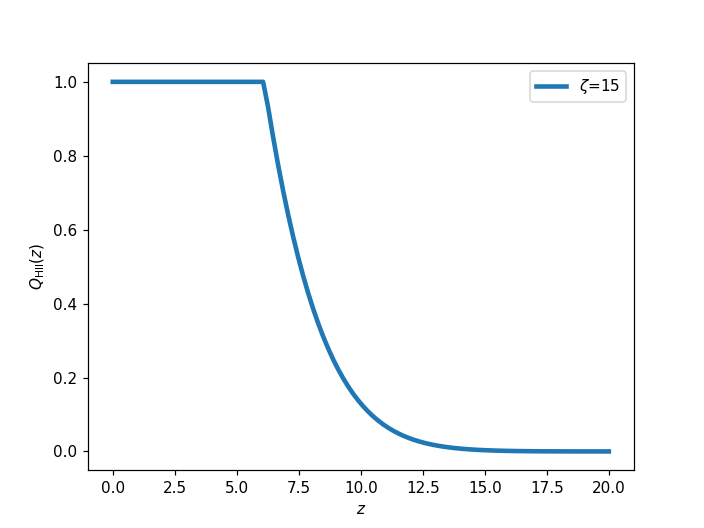

In [13]:
## set your parameters
######################
zeta = 15
clump = 3
M_min = 1e8
######################

Q_arr = get_Q_arr(clump,zeta,M_min,cosmo)
plt.plot(z_arr, Q_arr, label=r'$\zeta$=' + format(zeta),linewidth=3)
plt.xlabel(r'$z$')
plt.ylabel(r'$Q_{\mathrm{HII}}(z)$')
plt.legend()
plt.show()

# An example to get reionization histories with different $\zeta$


/home/bmaity/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


zeta = 10 reion end = 5.1


<IPython.core.display.Javascript object>


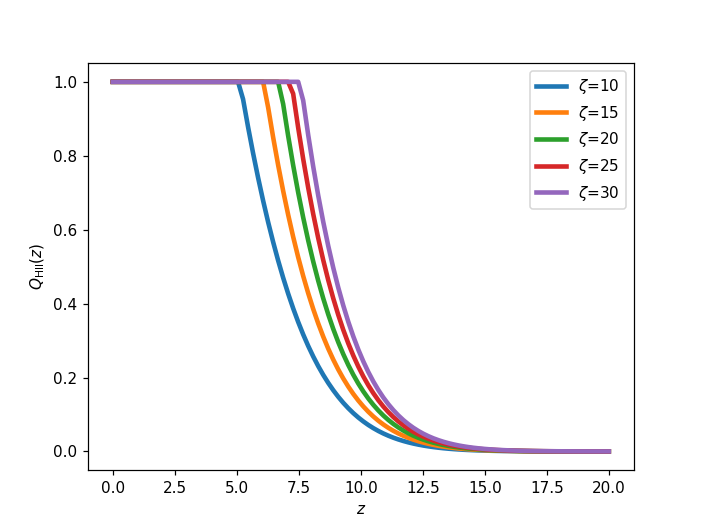

/home/bmaity/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/home/bmaity/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


zeta = 15 reion end = 6.1
zeta = 20 reion end = 6.7
zeta = 25 reion end = 7.1


/home/bmaity/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/home/bmaity/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


zeta = 30 reion end = 7.5


In [18]:
## CHECK REIONIZATION HISTORIES FOR DIFFERENT IONIZATION EFFICIENCY 
###################################################################

import numpy as np
from scipy import integrate

clump = 3
M_min=1e8
zeta_arr = np.array([10,15,20,25,30])  ## GIVE ARRAY CONTAINING ZETA
for i in range(0,len(zeta_arr)):
    zeta = zeta_arr[i]
    Q_arr = get_Q_arr(clump,zeta,M_min,cosmo)
    z_end = z_arr[np.argmax(Q_arr == 1.0)]
    print('zeta =',zeta, 'reion end =', round(z_end,1))
    plt.plot(z_arr, Q_arr, label=r'$\zeta$=' + format(zeta),linewidth=3)
plt.xlabel(r'$z$')
plt.ylabel(r'$Q_{\mathrm{HII}}(z)$')
plt.legend()
plt.show()

# An example to get CMB scattering optical depth $\tau_e$

In [15]:
## DEFINE A FUNCTION TO COMPUTE CMB SCATTERING OPTICAL DEPTH
###########################################################

def tau_func(clump,zeta,Mmin,cosmo):
    Q_arr = get_Q_arr(clump,zeta,Mmin,cosmo)
    z_end = z_arr[np.argmax(Q_arr == 1.0)]
    x_ionHe_arr = np.zeros_like(Q_arr)
    tau_arr = cosmolopy.reionization.integrate_optical_depth(Q_arr[::-1], x_ionHe_arr, z_arr[::-1], **cosmo)
    tau_arr = tau_arr[::-1]
    return tau_arr,Q_arr

/home/bmaity/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


<IPython.core.display.Javascript object>


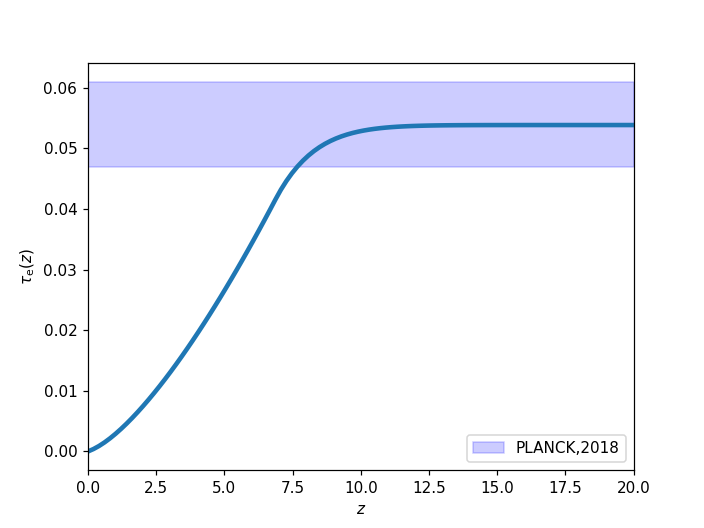

$\tau_e$ =  0.054


In [20]:
## CHECK THE TAU VALUES
#######################

clump = 1
zeta = 35
M_min =1.e9
tau_arr,Q_arr = tau_func(clump,zeta,M_min,cosmo)
plt.plot(z_arr, tau_arr,linewidth=3)
plt.xlabel(r'$z$')
plt.ylabel(r'$\tau_{\mathrm{e}}(z)$')
print(r'$\tau_e$ = ', round(tau_arr[0],3))


#PLOT OBSERVATIONAL CONSTRAINTS
###############################

x =  np.linspace(0,20)
y1 = [0.061] ## PLANCK UPPER LIMITS
y2 = [0.047] ## PLANCK LOWER LIMITS


plt.fill_between(x, y1, y2,
                 facecolor="orange", # The fill color
                 color='blue',       # The outline color
                 alpha=0.2,label='PLANCK,2018')          # Transparency of the fill
plt.xlim(np.min(z_arr),np.max(z_arr))
plt.legend(loc='lower right')
plt.show()


# An example for computing ionizing photon efficiency ($\dot{N}_{\gamma}$)

In [16]:
## DEFINE FUNCTION FOR COMPUTING IONIZING EFFICIENCY
####################################################
def ion_emiss(zeta, Mmin, cosmo):
    ignore, ignore, ignore, n_H_0 = cosmolopy.density.baryon_densities(**cosmo)
    fcoll_arr = cosmolopy.perturbation.collapse_fraction(*cosmolopy.perturbation.sig_del(Mmin, z_arr, passed_min_mass=True, **cosmo)) 
    dfcoll = np.diff(fcoll_arr)
    dz = np.diff(z_arr)
    H_arr = (cosmolopy.distance.hubble_z(z_arr, **cosmo) * (1. + z_arr))
    H_arr = np.delete(H_arr,0)
    print(len(H_arr),len(dz))
    return -(n_H_0 * zeta * dfcoll/dz) * H_arr

99 99


/home/bmaity/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


<IPython.core.display.Javascript object>


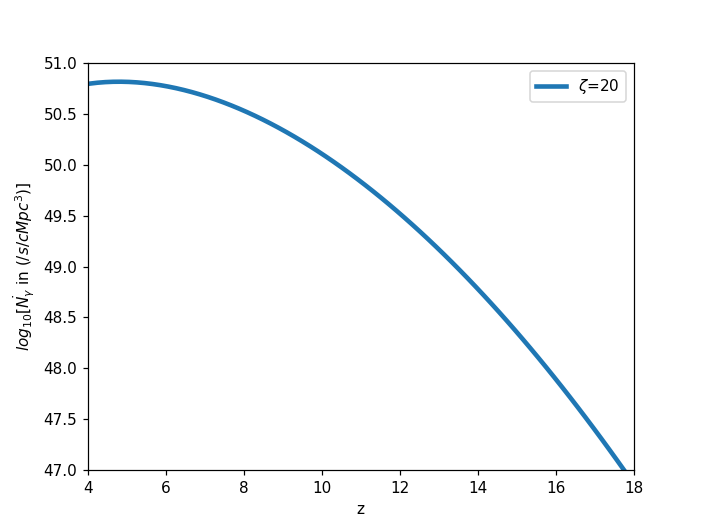

In [19]:
Mmin = 1e9
zeta = 20
plt.plot(np.delete(z_arr,0),np.log10(ion_emiss(zeta,Mmin,cosmo)),label='$\zeta$='+format(zeta),linewidth=3)
plt.xlabel('z')
plt.ylabel('$log_{10}[\dot{N_{\gamma}}$ in $(/s/cMpc^3)]$')
#plt.yscale('log')
plt.xlim(4,18)
plt.ylim(47,51)
plt.legend()


#z_5 = 5
#log_emiss_5 = np.array([50.59,0.09,0.07]) # Log_emissivity, upper limit, lower limit (using Bolton & Haehnelt, 2007)
##print(len(log_emiss_5[2]))
#plt.errorbar(z_5,log_emiss_5[0],np.array([[log_emiss_5[1],log_emiss_5[2]]]).T, color='red', fmt='ko')
##plt.errorbar(3, 5, xerr=np.array([[1,2]]).T,fmt='ko', )
##plt.scatter(z_5,10**log_emiss_5[0])
#plt.show()